# Simulating **Qiskit Metal** Designs with **palace** and **SQDMetal**

This tutorial explores the simulation of [Qiskit Metal](https://github.com/qiskit-community/qiskit-metal)  `design` objects using `palace`, facilitated by `SQDMetal`. The design of quantum devices, the foundation of the quantum ecosystem, is a multi-step process. Qiskit Metal endeavors to simplify and organize this undertaking.

**About Qiskit Metal**

[Qiskit Metal](https://github.com/qiskit-community/qiskit-metal) 
 \( [docs here](https://qiskit-community.github.io/qiskit-metal/index.html), [tutorials here](https://qiskit-community.github.io/qiskit-metal/tut/index.html)  \)  aims to provide a community-driven platform for quantum chip development, from concept to layout to electromagentics to Hamiltonians and to fabrication, within an open framework. It aims to foster innovation and make the design of quantum devices more accessible.  By automating and building in best practices, testing on real devices, Metal aims to make quantum hardware modeling more straightforward, reduce errors, and improve design speed.  It was started and led by Zlatko Minev, developed with the IBM Qiskit Metal team and many open-source contributors. It employs the permissive Apache 2.0 license and is now a community-maintained open-source package.

 The [Qiskit Metal tutorials](https://qiskit-community.github.io/qiskit-metal/tut/index.html) and [20+ videos on YouTube](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqHl5ZqVmhB_FcSqmLufsjb) offer a good starting point for exploration.

**Contributing to the Future of Device Design**

The continued development of Qiskit Metal relies on its community. If you have an interest in quantum hardware and wish to contribute, consider becoming a maintainer or exploring funding opportunities. We invite you to the **Quantum Metal and device design session**. This will be a discussion with Zlatko Minev, Eli Levinson Falk, and other key figures in the Metal community about its future, the formation of a board of directors, and a maintainer group. If contributing to this effort interests you, we encourage you to connect at this workshop and **join the Thursday workshop on the future of Metal.** 


**What This Tutorial Covers**

Here, we will walk through electrostatic and eigenmode simulations of a qubit-cavity system. We will use `palace`, an open-source finite element analysis tool, through the `SQDMetal` interface. While Qiskit Metal also supports other tools like Elmer, this guide focuses on the `palace` integration.

We will learn to:
1.  Define a qubit-cavity system in Qiskit Metal.
2.  Prepare this design for simulation with `SQDMetal`.
3.  Run electrostatic simulations in `palace` to examine charge distributions and capacitances.
4.  Conduct eigenmode simulations in `palace` to find resonant frequencies and mode profiles.

This tutorial aims to provide a working knowledge of how these open-source tools can be combined for the analysis of superconducting quantum circuits, helping to reveal the underlying physics at play.

**Requirements:**

* [ ] Ensure that [`SQDMetal`](https://github.com/sqdlab/SQDMetal) is installed in your environment. This package includes installation of Qiskit Metal.
* [ ] Ensure that [`palace`](https://github.com/sqdlab/palace) is installed in your environment. Instructions are [here](https://lfl-lab.github.io/SQuADDS/source/resources/palace.html).

Let us begin the exploration.

# Transmon + Resonator System

This module models the transmon qubit in the cooper-pair charge basis, assuming wrapped junction phase variable. The Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the gauge-invariant phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The variables are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensiuonless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


The Hamiltonian can be written in the charge ($\hat n$) basis as: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$
Where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$

### Hcpb class

Hamiltonian-model Cooper pair box (Hcpb) class.

Used to model analytically the CPB Hamiltonian quickly
and efficiently. Solves in charge basis tridiagonal eigenvalue
problem for arbitrary Ej, Ec, ng values.

As long as nlevels remains fixed the number of charge states
considered does not change and it does not recreate the arrays,
just recomputes the properties

Returns all properties of interest for the CPB.

This model is closer to the analytic solution than the Duffing oscillator model.
Can work backwards from target qubit parameters to get the Ej, Ec or use
input Ej, Ec to find the spectrum of the Cooper Pair Box.

In [3]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We can get a feel for how to use the Hcpb class by plotting the first few eigenvalues as a function of offset charge, similar to the plots reported in Phys. Rev. A 76, 042319 (2007.) Let's start by defining the range of offset charge from -2.0 to +2.0 and also by defining a normalization for the eigenvalues, which will be the transition energy between the first two states evaluated at the degenercy point where ng=0.5. For this exercise, we'll take Josephson Energy to be equal to the charging energy:

In [4]:
x = np.linspace(-2.0,2.0,101) # this represents the charging energy (ng)
H_norm = Hcpb(nlevels=2, Ej=1000.0, Ec=1000.0, ng=0.5) # Hamiltonian definition 
norm = H_norm.fij(0,1) # normalization constant 

Next, we'll sweep over the offset charge and calculate the first three eigenvalues for a given value of ng. We'll need to define a new Hamiltonian for this. 

In [5]:
E0, E1, E2 = [], [], []

# For a given value of offset charge (ng, represented by x) we will calculate the CPB Hamiltonian using the previously assigned values of E_J and E_C. Then we calculate the eigenvalue for a given value of m.
for i in x: 
    H = Hcpb(nlevels=3, Ej=1000.0, Ec=1000.0, ng=i)
    E0.append(H.evalue_k(0)/norm)
    E1.append(H.evalue_k(1)/norm)
    E2.append(H.evalue_k(2)/norm)

# define the minimum of E0 and set this to E=0
floor = min(E0) 
 
plt.plot(x, E0 - floor, 'k', label="m=0")
plt.plot(x, E1 - floor, 'r', label="m=1")
plt.plot(x, E2 - floor, 'b', label="m=2")
plt.xlabel("ng")
plt.ylabel("Em/E01")
plt.legend(title="Energy Level:", loc='upper right')
plt.show()

# Wavefunction

Let's define a new Hamiltonian, this time with $E_{J} >> E_{C}$ and an offset charge of $ng=0.001$. We can calculate the transition energy between the lowest two states as well as the anharmonicity with the following: 

In [17]:
H = Hcpb(nlevels=3, Ej=13971.3, Ec=295.2, ng=0.001)
print(f"""
Transmon frequencies 

 ω01/2π = {H.fij(0,1): 6.0f} MHz
   α/2π = {H.anharm(): 6.0f} MHz
""")



Transmon frequencies 

 ω01/2π =   5604 MHz
   α/2π =     11 MHz



In [6]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=f"|{k}>") # it's in either quadrature, but not both
plt.xlabel("Junction phase θ (wrapped in the interval [-π, π])")
plt.ylabel("Re(ψ(θ))")
plt.legend(title="Level")
plt.show()

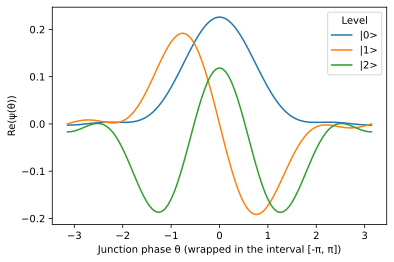

In [ ]:
import matplotlib.pyplot as plt
for k in range (3):
    ψ, θ = H.psi_k(k,101)
    plt.plot(θ, ψ.real+ψ.imag, label=f"|{k}>") # it's in either quadrature, but not both
plt.xlabel("Junction phase θ (wrapped in the interval [-π, π])")
plt.ylabel("Re(ψ(θ))")
plt.legend(title="Level")

### Verifying Orthonormality of the Wavefunctions

Here, we can verify the orthonormality of the wavefunctions. Let's first take the first two eigenstates and verify that their inner product is zero, thereby confirming orthogonality. Note that since the wavefunctions can be complex, we need to take the complex conjugate of $\Psi1$. 

In [7]:
Psi0, theta0 = H.psi_k(0)
Psi1, theta1 = H.psi_k(1)
print(np.dot(Psi0,Psi1.conj()))

(-7.458480481430543e-05-4.212048520991138e-17j)


Indeed, we see that the dot product is essentially zero (within numerical precision.) Next, let's take the inner product of the first eigenstate with itself, checking that we get an output of unity:

In [8]:
print(np.dot(Psi0, Psi0.conj()))
print(np.dot(Psi1, Psi1.conj()))

(1.0000000000000002+5.450237162700861e-36j)
(1.0000000000000002+7.994088637294566e-37j)


Indeed we see that the dot products are essentially equal to unity, confirming that the states are appropriately normalized.  

# Additional Analysis: Charge Dispersion, Energy Level Differences, Anharmonicity and Dephasing Time (T2)

### Charge Dispersion

The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_{m} = E_{m}(n_{g}=0.5) - E_{m}(n_{g}=0.0)$. We can plot $\epsilon_{m}/E_{01}$ as a function of $E_{J}/E_{C}$ for the first few energy levels and reproduce the figure published in Phys. Rev. A 76, 042319 (2007) (Figure 4(a)). 

We can start by defining a value of charging energy and creating empty lists for $\epsilon_{0}$ through $\epsilon_{4}$: 

In [9]:
E_c=100.0 # charging energy 
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)           # this this ratio of Ej/Ec which will go on the x-axis. 

Next, we simply evaluate the expression given above for $\epsilon_{m}$ based on $E_{m}$ and $E_{0}$. We use two separate Hamiltonians to do this; one evaluated at $n_{g}=0.5$ and one evaluated at $n_{g}=0.0$. We also normalize by the transition energy between the lowest two states evaluated at the degeneracy point ($E_{01}$.) Finally, we populate the lists each $\epsilon_{m}$. 

In [10]:
for i in x:
    E_j = i*E_c 
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    
    H_norm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    norm = H_norm.fij(0,1)                         # normalization constant 
    
    epsilon0.append(abs(H_half.evalue_k(0) - H_zero.evalue_k(0))/norm)
    epsilon1.append(abs(H_half.evalue_k(1) - H_zero.evalue_k(1))/norm)
    epsilon2.append(abs(H_half.evalue_k(2) - H_zero.evalue_k(2))/norm)
    epsilon3.append(abs(H_half.evalue_k(3) - H_zero.evalue_k(3))/norm)

We can plot these values to see the exponential decrease in the charge dispersion with increasing $E_{J}/E_{C}$: 

In [11]:
plt.plot(x, epsilon0, 'k', label="m=0")
plt.plot(x, epsilon1, 'b', label="m=1")
plt.plot(x, epsilon2, 'r', label="m=2")
plt.plot(x, epsilon3, 'g', label="m=3") 
plt.yscale("log")
plt.xlabel("EJ/Ec")
plt.ylabel("Epsilon/E01")
plt.legend(title="Energy Level", loc='upper right')

In [13]:
import scqubits as scq

In [14]:
qubit = scq.Transmon(
    EJ=13.97124102543,
    EC=0.295179,
    ng=0.001,
    ncut=40,
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)
evals = qubit.eigenvals(evals_count=12)
print(f"freq = {(evals[1] - evals[0])* 1000:.0f} MHz")
print(f"alpha = {((evals[2] - evals[1]) - (evals[1] - evals[0]))* 1000:.0f} MHz")

freq = 5431 MHz
alpha = -341 MHz


In [15]:
qubit.plot_n_wavefunction()
qubit.plot_phi_wavefunction(which=[0,1,2], mode='real')
qubit.hamiltonian()

array([[1889.24005846,   -6.98562051,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  -6.98562051, 1795.96113303,   -6.98562051, ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,   -6.98562051, 1705.0436396 , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ..., 1704.86417076,
          -6.98562051,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,   -6.98562051,
        1795.77694133,   -6.98562051],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
          -6.98562051, 1889.0511439 ]])

In [16]:
import numpy as np
ng_list = np.linspace(-2, 2, 220)
qubit.plot_evals_vs_paramvals('ng', ng_list, evals_count=6, subtract_ground=False);

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

In [17]:
EJvals = np.linspace(0.1, 50, 100)
qubit.plot_dispersion_vs_paramvals('ng', 'EJ', EJvals, ref_param='EC', transitions=(((0,1), (0,2))));

EJvals = np.linspace(0.1, 50, 35)
qubit.plot_dispersion_vs_paramvals('ng', 'EJ', EJvals, ref_param='EC', levels=(0,1,2));

Spectral data:   0%|          | 0/100 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/100 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/35 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/35 [00:00<?, ?it/s]

# Tunable Transmon

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scqubits as scq

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

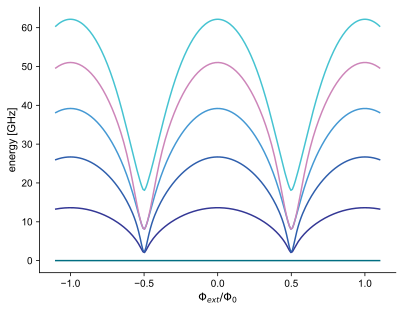

In [2]:
tune_tmon = scq.TunableTransmon(
    EJmax=50.0,
    EC=0.5,
    d=0.01,
    flux=0.0,
    ng=0.0,
    ncut=30
)

flux_list = np.linspace(-1.1, 1.1, 220)
tune_tmon.plot_evals_vs_paramvals('flux', flux_list, subtract_ground=True);

## The Jaynes-Cummings model

The Jaynes-Cummings mode describes a system composed of a qubit (two-level system) coupled to a harmonic oscillator. The coupling is such that a qubit excitation can be "converted" into a photon and vice versa,

$\displaystyle H=-\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g (a\sigma_+ + a^\dagger \sigma_-)$

This model can be solved exactly, resulting in the following eigenenergies:

$\displaystyle E_0 = -\frac{1}{2}\omega_q$,

$\displaystyle E_{n\pm} =  \bigg(n-\frac{1}{2}\bigg) \omega_r \pm \sqrt{\frac{\Delta^2}{4}+n g^2}$,

where $\Delta=\omega_r-\omega_q$ and $n=1,2,\ldots$.

Let's simulate the transmon-resonator coupled system in scqubits first!

In [6]:
import numpy as np

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

In [7]:
# exact eigenenergies for comparing with numerics

def energies(frequency_r, frequency_q, g, n_cutoff):
    delta = frequency_r - frequency_q
    energies1 = (np.arange(1, n_cutoff) - 0.5) * frequency_r
    energies2 = np.sqrt(delta**2/4 + np.arange(1, n_cutoff) * g**2)
    energies_plus = energies1 + energies2
    energies_minus = energies1 - energies2
    energies_0 = np.asarray([[-0.5 * frequency_q]])
    all_energies = np.append(energies_0, energies_minus)
    all_energies = np.append(all_energies, energies_plus)
    return np.sort(all_energies)

In [8]:
frequency_q = 1.0
frequency_r = 0.8
g = 0.1


qubit = scq.GenericQubit(E=frequency_q)

osc = scq.Oscillator(
    E_osc=frequency_r,
    truncated_dim=10  # up to 9 photons
)

In [9]:
# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([qubit, osc])

hilbertspace.add_interaction(
    g_strength = g,
    op1 = qubit.sm_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

In [10]:
evals = hilbertspace.eigenvals(evals_count=5)
print(evals)

[-0.5         0.25857864  0.54142136  1.02679492  1.37320508]


In [11]:
energies(frequency_r, frequency_q, g, 3)

array([-0.5       ,  0.25857864,  0.54142136,  1.02679492,  1.37320508])

# Drawing transmon + resonator system

In [12]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander


In [13]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)



design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
readout = RouteMeander(design, 'readout',  Dict(
            total_length='6 mm',
            hfss_wire_bonds = True,
            fillet='90 um',
            lead = dict(start_straight='100um'),
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='readout'),
                end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()




03:59PM 56s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Populating font family aliases took 159 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 



In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()

In [35]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solns_to_save": 4,                                #number of electromagnetic field visualizations to save
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-4,                              #error residual tolerance for iterative solver
                "solver_maxits": 50,                              #number of solver iterations
                "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                "mesh_min": 1e-3,                                 #minimum element size for the mesh in mm
                "mesh_sampling": 120,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 2,                                      #number of CPU cores to use for simulation
                "palace_dir":"/Users/mcansarihan/qubit_design/palace/build/bin/palace"
                }


In [36]:
#Creat the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'xmon_cap_sim_GMSH',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "/Users/mcansarihan/qubit_design/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
cap_sim.fine_mesh_in_rectangle(*list(design.components["Q1"].qgeometry_bounds()), mesh_sampling=130, mesh_min=15e-3, mesh_max=120e-3)

In [37]:
cap_sim.prepare_simulation()

In [38]:
cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 2 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin xmon_cap_sim_GMSH.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 2 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 948 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 292 duplicate vertices for interior boundaries in the mesh
Added 888 duplicate boundary elements for interior boundaries in the mesh
Added 12 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 2 subdomains

Characteristic length and time scales:
 L₀ = 2.400e-03 m, t₀ = 8.006e-03 ns

Me

array([[ 1.00000000e+00,  6.75587217e-11, -6.68258732e-11,
         0.00000000e+00, -7.18308917e-13],
       [ 2.00000000e+00, -6.68258732e-11,  6.79665106e-11,
        -1.88949731e-13, -8.95644528e-14],
       [ 3.00000000e+00,  0.00000000e+00, -1.88949731e-13,
         1.31275737e-12, -1.10660460e-12],
       [ 4.00000000e+00, -7.18308917e-13, -8.95644528e-14,
        -1.10660460e-12,  1.92569760e-12]])

In [39]:
import pandas as pd
import json
import pprint

def read_csv_to_dataframe(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)  # Skip the first row which is the header
    return df

def dataframe_to_json(df):
    # Convert values from F to fF
    df.iloc[:, 1:] *= 1e15

    # Extract values
    ground_to_ground = abs(df.iloc[0, 1])
    cross_to_ground = abs(df.iloc[1, 1])
    cross_to_cross = abs(df.iloc[1, 2])
    claw_to_ground = abs(df.iloc[2, 1])
    claw_to_cross = abs(df.iloc[2, 2])
    claw_to_claw = abs(df.iloc[2, 3])

    # Create the result dictionary
    result = {
        "claw_to_claw": claw_to_claw,
        "claw_to_ground": claw_to_ground,
        "cross_to_claw": claw_to_cross,
        "cross_to_cross": cross_to_cross,
        "cross_to_ground": cross_to_ground,
        "ground_to_ground": ground_to_ground,
        "units": "fF"
    }

    # Convert the result dictionary to JSON
    result_json = json.dumps(result, indent=4)
    return result_json


In [42]:
cap_matrix_df = read_csv_to_dataframe("/Users/mcansarihan/qubit_design/xmon_cap_sim_GMSH/outputFiles/terminal-C.csv")
cap_matrix = dataframe_to_json(cap_matrix_df)
pprint.pprint(json.loads(cap_matrix)) 

{'claw_to_claw': 1312.757368215,
 'claw_to_ground': 0.0,
 'cross_to_claw': 188.9497309427,
 'cross_to_cross': 67966.51063697001,
 'cross_to_ground': 66825.87316149002,
 'ground_to_ground': 67558.72168877,
 'units': 'fF'}


In [ ]:
## Eigenmodal Simulation

### For a qubit-cavity system
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
from squadds.components.qubits import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import numpy as np
import matplotlib.pyplot as plt
from SQDMetal.Comps.Xmon import Xmon
from SQDMetal.Comps.Junctions import JunctionDolanPinStretch
from SQDMetal.Comps.Capacitors import CapacitorProngPin
design.delete_all_components
design = designs.DesignPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 
Lets create the qubit with a junction and a claw

### Qubit
# Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0.375mm', pos_y='-1.3',
                                    vBar_width='24um', hBar_width='24um', vBar_gap=f'{16}um', hBar_gap=f'{16}um',
                                    cross_width=f'{60*2+24}um', cross_height=f'{60*2+24}um',
                                    gap_up='24um', gap_left='24um', gap_right='24um', gap_down='24um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend='24um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='4um', prong_length='10um', pin_gap_side='4um',
                                                gap_side='10um', pad_thickness='20um',
                                                gap_front='10um', gap_back='5um', trace_width='10um'))
Now lets add the resonator and feedline
# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width ='10um',
                                            trace_gap ='6um',
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))

#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = False,
        fillet='99.9 um',
        lead = dict(start_straight='300um'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))
Check the design
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit-cavity.png')
Define the hyper-parameters for the eigenmode simulation
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 2e9,                              #starting frequency in Hz 
                 "number_of_freqs": 6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-3,                              #error residual tolerance foriterative solver
                 "solver_maxits": 3,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 10,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files

Assigning the materials to the interfaces, add ports to the design, and add some mesh.
from SQDMetal.Utilities.Materials import MaterialInterface

eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
eigen_sim.fine_mesh_in_rectangle(0.2875e-3, -1.2e-3, 0.63e-3, -1.72e-3, min_size=15e-6, max_size=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
eigen_sim.create_port_JosephsonJunction('junction', L_J=10e-9, C_J=10e-15)

# #Fine-mesh routed paths
eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))
eigen_sim.prepare_simulation()
Checking the meshfile
gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
gmsh_nav.open_GUI()
If all looks good, lets run the simulation
eigen_sim.run()
Reading the eigenmode data now
eigen_df = read_csv_to_dataframe("sims/GMSH_eigen_test/outputFiles/eig.csv")
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

## Eigenmodal Simulation

### For a qubit-cavity system

In [ ]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
from squadds.components.qubits import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from SQDMetal.Comps.Xmon import Xmon
from SQDMetal.Comps.Junctions import JunctionDolanPinStretch
from SQDMetal.Comps.Capacitors import CapacitorProngPin

In [ ]:
design.delete_all_components

In [ ]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 

Lets create the qubit with a junction and a claw

### Qubit

In [ ]:
# Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0.375mm', pos_y='-1.3',
                                    vBar_width='24um', hBar_width='24um', vBar_gap=f'{16}um', hBar_gap=f'{16}um',
                                    cross_width=f'{60*2+24}um', cross_height=f'{60*2+24}um',
                                    gap_up='24um', gap_left='24um', gap_right='24um', gap_down='24um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend='24um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='4um', prong_length='10um', pin_gap_side='4um',
                                                gap_side='10um', pad_thickness='20um',
                                                gap_front='10um', gap_back='5um', trace_width='10um'))

Now lets add the resonator and feedline

In [ ]:
# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width ='10um',
                                            trace_gap ='6um',
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


In [ ]:
#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = False,
        fillet='99.9 um',
        lead = dict(start_straight='300um'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))

Check the design

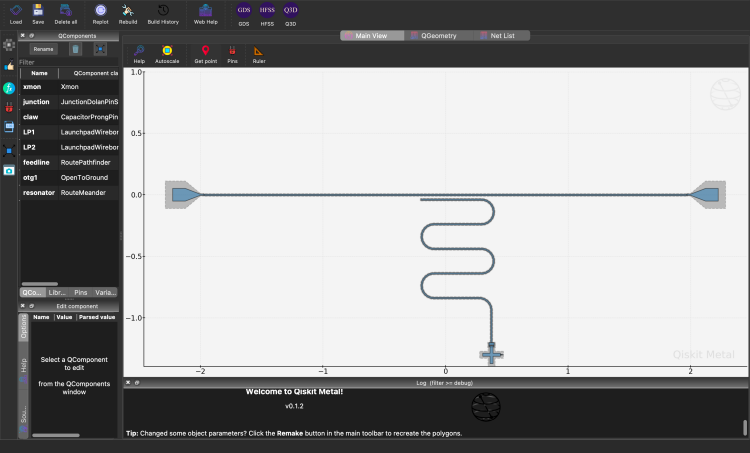

In [ ]:
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit-cavity.png')

Define the hyper-parameters for the eigenmode simulation

In [ ]:
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 2e9,                              #starting frequency in Hz 
                 "number_of_freqs": 6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-3,                              #error residual tolerance foriterative solver
                 "solver_maxits": 3,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 10,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files


Assigning the materials to the interfaces, add ports to the design, and add some mesh.

In [ ]:
from SQDMetal.Utilities.Materials import MaterialInterface

eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
eigen_sim.fine_mesh_in_rectangle(0.2875e-3, -1.2e-3, 0.63e-3, -1.72e-3, min_size=15e-6, max_size=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
eigen_sim.create_port_JosephsonJunction('junction', L_J=10e-9, C_J=10e-15)

# #Fine-mesh routed paths
eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))

junction_index 0
comp_id 2
gsdf   component    name                                         geometry  layer  \
0         2  design  LINESTRING (0.44700 -1.30000, 0.47100 -1.30000)      2   

   subtract  helper  chip   width hfss_inductance  hfss_capacitance  \
0     False   False  main  0.0054            10nH                 0   

   hfss_resistance  hfss_mesh_kw_jj q3d_inductance  q3d_capacitance  \
0                0         0.000007           10nH                0   

   q3d_resistance  q3d_mesh_kw_jj      gds_cell_name  
0               0        0.000007  my_other_junction  
gsdf   component    name                                         geometry  layer  \
0         2  design  LINESTRING (0.44700 -1.30000, 0.47100 -1.30000)      2   

   subtract  helper  chip   width hfss_inductance  hfss_capacitance  \
0     False   False  main  0.0054            10nH                 0   

   hfss_resistance  hfss_mesh_kw_jj q3d_inductance  q3d_capacitance  \
0                0         0.000007

In [ ]:
eigen_sim.prepare_simulation()

Checking the meshfile

In [ ]:
gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
gmsh_nav.open_GUI()

If all looks good, lets run the simulation

In [ ]:
eigen_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/shanto/LFL/palace/build/bin/palace-arm64.bin GMSH_eigen_test.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/

Git changeset ID: v0.13.0-117-g748660c
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 2628 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 5317 duplicate vertices for interior boundaries in the mesh
Added 12451 duplicate boundary elements for interior boundaries in the mesh
Added 1554 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 5.520e-03 m, t₀ = 1.841e-02 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-2.760e-03, -2.440e-03, -2.800e-

Reading the eigenmode data now

In [ ]:
eigen_df = read_csv_to_dataframe("sims/GMSH_eigen_test/outputFiles/eig.csv")
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df